In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import argparse
from pathlib import Path


In [3]:
from june.geography import Geography
from june.demography.demography import (
    load_age_and_sex_generators_for_bins,
    Demography,
    Population,
    load_comorbidity_data,
    generate_comorbidity,
)
from june.paths import data_path, configs_path
from june.epidemiology.epidemiology import Epidemiology
from june.epidemiology.infection import ImmunitySetter
from june.epidemiology.infection import Infection, HealthIndexGenerator, InfectionSelector, InfectionSelectors
from june.epidemiology.infection_seed import InfectionSeed, InfectionSeeds
from june.interaction import Interaction
from june.groups import Hospital, Hospitals, Cemeteries
from june.distributors import HospitalDistributor
from june.hdf5_savers import generate_world_from_hdf5
from june.policy import Policy, Policies
from june.records import Record
from june.simulator import Simulator
from june.records import Record, RecordReader

from june.tracker.tracker import Tracker

from camps.activity import CampActivityManager
from camps.paths import camp_data_path, camp_configs_path
from camps.world import World
from camps.groups.leisure import generate_leisure_for_world, generate_leisure_for_config
from camps.camp_creation import (
    generate_empty_world,
    populate_world,
    distribute_people_to_households,
)  # this is loaded from the ../camp_scripts folder



No --data argument given - defaulting to:
/home/joseph/Documents/PhD/UN_Work/JUNE/data
No --configs argument given - defaulting to:
/home/joseph/Documents/PhD/UN_Work/JUNE/june/configs


2022-02-07 13:58:00,470 - camps.paths - WARNING - No --camp_data argument given - defaulting to:
/home/joseph/Documents/PhD/UN_Work/UNGP-settlement-modelling-private/camp_data
2022-02-07 13:58:00,470 - camps.paths - WARNING - No --configs_camps argument given - defaulting to:
/home/joseph/Documents/PhD/UN_Work/UNGP-settlement-modelling-private/configs_camps


In [4]:
from camps.groups import PumpLatrines, PumpLatrineDistributor
from camps.groups import DistributionCenters, DistributionCenterDistributor
from camps.groups import Communals, CommunalDistributor
from camps.groups import FemaleCommunals, FemaleCommunalDistributor
from camps.groups import Religiouss, ReligiousDistributor
from camps.groups import Shelter, Shelters, ShelterDistributor
from camps.groups import IsolationUnit, IsolationUnits
from camps.groups import LearningCenters
from camps.distributors import LearningCenterDistributor
from camps.groups import PlayGroups, PlayGroupDistributor
from camps.groups import EVouchers, EVoucherDistributor
from camps.groups import NFDistributionCenters, NFDistributionCenterDistributor
from camps.groups import SheltersVisitsDistributor

In [5]:
Results_Path = Path("/home/joseph/Documents/PhD/UN_Work/Results")

Config_File_Path = camp_configs_path / "config_demo.yaml"
Interactions_File_Path= camp_configs_path / "defaults/interaction/ContactInteraction_subgroups.yaml"
Policies_File_Path = camp_configs_path / "defaults/policy/home_care_policy.yaml"

Hospitals_File_Path = camp_data_path / "input/hospitals/hospitals.csv"

comorbidity_multipliers_path = camp_configs_path / "defaults/comorbidities.yaml"
male_comorbidity_reference_prevalence_path = camp_data_path / "input/demography/uk_male_comorbidities.csv"
female_comorbidity_reference_prevalence_path = camp_data_path / "input/demography/uk_female_comorbidities.csv"

## Initialize the world

When we create the camp to be simulated, we call this the 'world'. The world is initialised after specifying which geographical regions you want to simulate. We can do this by using the `filter_key` argument in the `generate_empty_world` function. Cox's Bazar Expansion Site is made up of camps (which we call regions), UNHCR blocks (which we call super areas) and Mahjee blocks (which we call areas). These are the 3 heirarchical levels on which our model works. You can pass lists of the regions/super_areas/areas to the function here. Alternatively, by leaving the function empty you can generate the entire Cox's Bazar Expansion Site consisting of 112 super areas.

In [6]:
# create empty world's geography
world = generate_empty_world(filter_key = {"region" : ["CXB-219"]})

2022-02-07 13:58:00,928 - june.geography.geography - INFO - There are 65 areas and 4 super_areas and 1 regions in the world.


In [7]:
# populate empty world
populate_world(world)

In [8]:
# distribute people to households
distribute_people_to_households(world)

In [9]:
# distirbute hospitals
hospitals = Hospitals.from_file(
    filename=Hospitals_File_Path
)
for hospital in hospitals:
    hospital.area = world.areas.get_closest_area(hospital.coordinates)
world.hospitals = hospitals
hospital_distributor = HospitalDistributor(
    hospitals, medic_min_age=20, patients_per_medic=10
)
hospital_distributor.assign_closest_hospitals_to_super_areas(
    world.super_areas
)
hospital_distributor.distribute_medics_from_world(world.people)

2022-02-07 13:58:04,361 - hospitals - INFO - There are 8 hospitals in the world.


In [10]:
world.pump_latrines = PumpLatrines.for_areas(world.areas)
world.play_groups = PlayGroups.for_areas(world.areas)
world.distribution_centers = DistributionCenters.for_areas(world.areas)
world.communals = Communals.for_areas(world.areas)
world.female_communals = FemaleCommunals.for_areas(world.areas)
world.religiouss = Religiouss.for_areas(world.areas)
world.e_vouchers = EVouchers.for_areas(world.areas)
world.n_f_distribution_centers = NFDistributionCenters.for_areas(world.areas)

2022-02-07 13:58:04,403 - social_venue - INFO - Domain 0 has 225 pump_latrines(s)
2022-02-07 13:58:04,427 - social_venue - INFO - Domain 0 has 500 play_groups(s)
2022-02-07 13:58:04,433 - social_venue - INFO - Domain 0 has 7 distribution_centers(s)
2022-02-07 13:58:04,472 - social_venue - INFO - Domain 0 has 125 communals(s)
2022-02-07 13:58:04,492 - social_venue - INFO - Domain 0 has 67 female_communals(s)
2022-02-07 13:58:04,931 - social_venue - INFO - Domain 0 has 2064 religiouss(s)
2022-02-07 13:58:04,939 - social_venue - INFO - Domain 0 has 7 e_vouchers(s)
2022-02-07 13:58:04,955 - social_venue - INFO - Domain 0 has 36 n_f_distribution_centers(s)


In [11]:
world.cemeteries = Cemeteries()

## Geography exploration

The geography is initialised first and can be explored.

### UNHCR camp blocks inside the World

In [12]:
super_areas = []
for super_area in world.super_areas:
    super_areas.append(super_area.name)

In [13]:
super_areas[:5]

['CXB-219-A', 'CXB-219-B', 'CXB-219-C', 'CXB-219-D']

### Mahjee blocks inside World

In [14]:
areas = []
for area in world.areas:
    areas.append(area.name)

In [15]:
areas[:5]

['CXB-219-001', 'CXB-219-002', 'CXB-219-003', 'CXB-219-004', 'CXB-219-005']

## Demography exploration

Once we have populated the 'digital twin' we can explore some of the attributes of the people we have created in the simulation.

### UNHCR block residents

In [16]:
sample_ages = []
sample_sexes = []
for person in world.super_areas.members[0].people:
    sample_ages.append(person.age)
    sample_sexes.append(person.sex)

In [17]:
sample_sexes[:5], sample_ages[:5]

(['f', 'f', 'f', 'f', 'm'], [63, 40, 39, 37, 33])

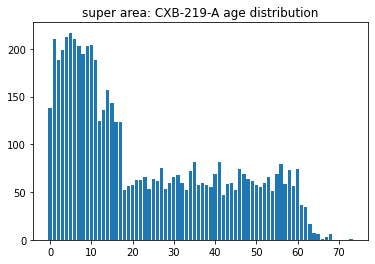

In [18]:
ages, counts = np.unique(sample_ages, return_counts=True)
plt.bar(ages, counts)
plt.title('super area: {} age distribution'.format(world.super_areas.members[0].name))
plt.show()

In [19]:
print ('The % children between ages 0-16 is {}%'.format(round(np.sum(counts[:16])/(np.sum(counts[:16])+np.sum(counts[16:]))*100)))

The % children between ages 0-16 is 49%


## Households

In this model, we will use the term 'family' and 'household' interchangeably. After populating the 'digital twin', we need to cluster people into families. To do this, we take account of age structure so that children live with adults, that there are some intergenerational households and such that we might also have some households of only adults.

### Household size distribution

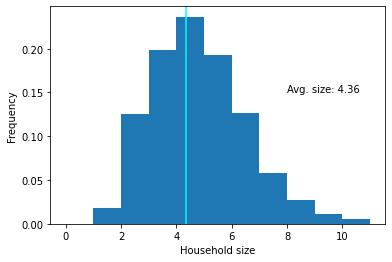

In [20]:
household_sizes = [household.size for household in world.households]
plt.hist(household_sizes, density=True, bins=np.arange(0,12))
plt.xlabel("Household size")
plt.ylabel("Frequency")
plt.axvline(np.mean(household_sizes), color="cyan")
plt.text(8, 0.150, f"Avg. size: {(np.mean(household_sizes)):.2f}")
plt.show()

# Shelters

Shelters house people in the camp. Since we know that families (houseohlds) often share shelters with other families, we can set the `sharing_shelter_ratio` to cluster families into shared shelters.

In [21]:
world.shelters = Shelters.for_areas(world.areas)
shelter_distributor = ShelterDistributor(sharing_shelter_ratio = 0.75) # proportion of families that share a shelter
for area in world.areas:
    shelter_distributor.distribute_people_in_shelters(area.shelters, area.households)

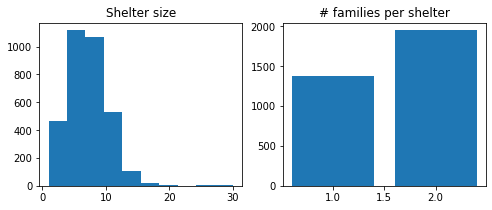

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
shelter_sizes = [shelter.size for shelter in world.shelters]
shelter_families = [shelter.n_families for shelter in world.shelters]
ax[0].hist(shelter_sizes)
ax[0].set_title("Shelter size")
shelter_families = {1 : len([shelter for shelter in world.shelters if shelter.n_families == 1]),
                    2 : len([shelter for shelter in world.shelters if shelter.n_families == 2])}
ax[1].bar(shelter_families.keys(), shelter_families.values())
ax[1].set_title("# families per shelter")
plt.show()

## Activity exploration

Once different activity locations are seeded in the 'digital twin' we can explore how many there are in different areas of the twin, and their coordinates to check they've all been added correctly.

### Pumps and latrines 

In [23]:
pumps_and_latrines = []
for pump_latrine in world.areas.members[0].pump_latrines:
    pumps_and_latrines.append(pump_latrine)

In [24]:
print ('There are {} pumps and latrines in area {}'.format(len(pumps_and_latrines), world.areas.members[0].name))

There are 4 pumps and latrines in area CXB-219-001


### Distribution centers

In [25]:
distribution_centers = []
for center in world.distribution_centers:
    distribution_centers.append(center)

In [26]:
distribution_centers[0].coordinates

array([21.21176333, 92.13597667])

### Non-food Distribution centers

In [27]:
non_food_distribution_centers = []
for center in world.n_f_distribution_centers:
    non_food_distribution_centers.append(center)

In [28]:
non_food_distribution_centers[0].coordinates

array([21.1962 , 92.14936])

### E-Voucher outlets

In [29]:
e_voucher_outlets = []
for center in world.e_vouchers:
    e_voucher_outlets.append(center)

In [30]:
e_voucher_outlets[0].coordinates

array([21.21176333, 92.13597667])

### Communal spaces

In [31]:
communal_spaces = []
for space in world.communals:
    communal_spaces.append(space)

In [32]:
communal_spaces[0].coordinates


array([21.19621, 92.14924])

### Female friendly communal spaces

In [33]:
female_communal_spaces = []
for space in world.female_communals:
    female_communal_spaces.append(space)

In [34]:
female_communal_spaces[0].coordinates

array([21.19588, 92.152  ])

### Religious sites

In [35]:
religious = []
for rel in world.religiouss:
    religious.append(rel)

In [36]:
religious[0].coordinates

array([21.20069, 92.15216])

# Adding the infection

The selector handles how infections are handled in the code. You can set different 'symptom trajectories' (e.g. exposed->mild->severe->hospitalised->intensive care) from different files. Here, we use the default.

In [37]:
selector = InfectionSelector.from_file()

In [38]:
selectors = InfectionSelectors([selector])

# Adding the interaction

The interaction class handles how many contacts people have in different locations and with who. If contact matrices are available, these can be coded in a `.yaml` file and fed into the class here.

In [39]:
interaction = Interaction.from_file(
    config_filename=Interactions_File_Path,
)

# Set policies

Policies control how 'operational interventions' are set in the camp. Here we set some social distancing policies, policies relating to medical care, such as people with severe symptoms being hospitalised, and individual and activity policies which can dynamically change how often and where people go, e.g. here, we close all female communal spaces and non-food distirbution centers which the camp did back in March

In [40]:
policies = Policies.from_file(
        Policies_File_Path,
        base_policy_modules=("june.policy", "camps.policy"),
    )

In [41]:
policies.policies

# Seed the disease

Set intial seeding conditions. This can be done at the camp level specifically, or generally by seeding them randomly. Here the `n_cases` is the number of randomly seeded people over the entire population.

In [42]:
infection_seed = InfectionSeed.from_uniform_cases(
    world=world, infection_selector=selector, cases_per_capita=0.01, date="2020-05-24"
)

In [43]:
infection_seeds = InfectionSeeds([infection_seed])

In [44]:
immunity_setter = ImmunitySetter.from_file_with_comorbidities(
    comorbidity_multipliers_path= comorbidity_multipliers_path,
    male_comorbidity_reference_prevalence_path= male_comorbidity_reference_prevalence_path,
    female_comorbidity_reference_prevalence_path = female_comorbidity_reference_prevalence_path,
    
)

In [45]:
epidemiology = Epidemiology(
    infection_selectors=selectors,
    infection_seeds=infection_seeds,
    immunity_setter=immunity_setter,
)

## Select config file

Before running the simualtion we must select the config file which defines how the world is set up and the simualtor will work. Specifically, the condif file specifies which activities will be included, how long we'll run the simualtion for, what the initial starting day will be and what the structure of weekdays and weekends will look like (if different)

In [46]:
CONFIG_PATH = Config_File_Path

# Initialise activities

The final step to intialising the simulator class which brings all of this together is to inialise all the activity distirbutors (the term 'leisure' is a legacy of the original version of this code used for modelling COVID-19 in the UK). This will mean that people know where they can go at and given time.

In [47]:
leisure = generate_leisure_for_config(world=world, config_filename=CONFIG_PATH)
leisure.leisure_distributors = {}
leisure.leisure_distributors["pump_latrine"] = PumpLatrineDistributor.from_config(
    world.pump_latrines
)
leisure.leisure_distributors["play_group"] = PlayGroupDistributor.from_config(
    world.play_groups
)
leisure.leisure_distributors[
    "distribution_center"
] = DistributionCenterDistributor.from_config(world.distribution_centers)
leisure.leisure_distributors["communal"] = CommunalDistributor.from_config(
    world.communals
)
leisure.leisure_distributors[
    "female_communals"
] = FemaleCommunalDistributor.from_config(world.female_communals)
leisure.leisure_distributors["religious"] = ReligiousDistributor.from_config(
    world.religiouss
)
leisure.leisure_distributors["e_voucher"] = EVoucherDistributor.from_config(
    world.e_vouchers
)
leisure.leisure_distributors[
    "n_f_distribution_center"
] = NFDistributionCenterDistributor.from_config(world.n_f_distribution_centers)
leisure.leisure_distributors[
    "shelters_visits"
] = SheltersVisitsDistributor.from_config()
leisure.leisure_distributors["shelters_visits"].link_shelters_to_shelters(
    world.super_areas
)
# associate social activities to shelters
leisure.distribute_social_venues_to_areas(world.areas, world.super_areas)

2022-02-07 13:58:06,698 - leisure - INFO - Linking households and care homes for visits
2022-02-07 13:58:06,698 - leisure - INFO - Done
2022-02-07 13:58:06,699 - leisure - INFO - Distributing social venues to areas
2022-02-07 13:58:06,699 - leisure - INFO - Distributed in 0 of 65 areas.
2022-02-07 13:58:06,786 - leisure - INFO - Distributed in 65 of 65 areas.


In [48]:
Tracker.ActivityManager = CampActivityManager
tracker = Tracker(
    world=world,
    pickle_path=Results_Path,
    group_types=[
        world.hospitals,
        world.distribution_centers,
        world.communals,
        world.female_communals,
        world.pump_latrines,
        world.religiouss,
        world.play_groups,
        world.e_vouchers,
        world.n_f_distribution_centers,
        world.shelters
    ],
    load_interactions_path=Interactions_File_Path,
)

# Initialise simulator and run

The recorder is defined which will log all interactions and infections in the simualation for later analysis. The `record_path` can be changed to any path where you want the recorded data to be stored.

In [49]:
record = Record(
    record_path=Results_Path, 
    record_static_data=True
)

The simulator is defined with all the different necessary components we have built up so far

In [50]:
Simulator.ActivityManager = CampActivityManager
simulator = Simulator.from_file(
    world=world,
    interaction=interaction,
    tracker=tracker,
    leisure=leisure,
    policies=policies,
    config_filename=CONFIG_PATH,
    epidemiology=epidemiology,
    record=record,
)


Finally we can run a small simualation

In [51]:
%%time
simulator.run()

2022-02-07 13:58:07,302 - simulator - INFO - Starting simulation for 35 days at day 2020-05-24 00:00:00,to run for 35 days
2022-02-07 13:58:07,765 - rank - INFO - Next timestep
2022-02-07 13:58:07,766 - simulator - INFO - ==================== timestep ====================
2022-02-07 13:58:07,920 - rank - INFO - Rank 0 -- move_people -- 0.15366211900072813
2022-02-07 13:58:07,921 - rank - INFO - Rank 0 -- move_people_waiting -- 9.907000276143663e-06
2022-02-07 13:58:07,924 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.014000973664224e-06,4.5299530029296875e-06 - 2020-05-24 00:00:00
2022-02-07 13:58:07,932 - simulator - INFO - Info for rank 0, Date = 2020-05-24 00:00:00, number of deaths =  0, number of infected = 247
2022-02-07 13:58:12,627 - rank - INFO - Rank 0 -- interaction -- 4.700078521998876
2022-02-07 13:58:12,628 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019157600036123767,0.00019168853759765625 - 2020-05-24 00:00:00
2022-02-07 13:58:12,8

2022-02-07 13:58:49,894 - simulator - INFO - Info for rank 0, Date = 2020-05-25 02:00:00, number of deaths =  0, number of infected = 290
2022-02-07 13:58:56,033 - rank - INFO - Rank 0 -- interaction -- 6.143182396999691
2022-02-07 13:58:56,037 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00015307899957406335,0.00015282630920410156 - 2020-05-25 02:00:00
2022-02-07 13:58:56,062 - rank - INFO - Rank 0 -- interaction_waiting -- 5.404001058195718e-06
2022-02-07 13:58:56,074 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011895929999809596,0.011896133422851562 - 2020-05-25 02:00:00

2022-02-07 13:58:56,075 - rank - INFO - Next timestep
2022-02-07 13:58:56,076 - simulator - INFO - ==================== timestep ====================
2022-02-07 13:58:56,499 - rank - INFO - Rank 0 -- move_people -- 0.4224962259995664
2022-02-07 13:58:56,500 - rank - INFO - Rank 0 -- move_people_waiting -- 5.081999916001223e-06
2022-02-07 13:58:56,500 - activity_manager - INFO - CMS: Peopl

2022-02-07 13:59:40,358 - rank - INFO - Next timestep
2022-02-07 13:59:40,359 - simulator - INFO - ==================== timestep ====================
2022-02-07 13:59:40,749 - rank - INFO - Rank 0 -- move_people -- 0.3899790680006845
2022-02-07 13:59:40,750 - rank - INFO - Rank 0 -- move_people_waiting -- 4.8719994083512574e-06
2022-02-07 13:59:40,750 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.622999090817757e-06,2.6226043701171875e-06 - 2020-05-26 06:00:00
2022-02-07 13:59:40,754 - simulator - INFO - Info for rank 0, Date = 2020-05-26 06:00:00, number of deaths =  0, number of infected = 418
2022-02-07 13:59:47,318 - rank - INFO - Rank 0 -- interaction -- 6.567615882000609
2022-02-07 13:59:47,323 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002801179998641601,0.00028014183044433594 - 2020-05-26 06:00:00
2022-02-07 13:59:47,346 - rank - INFO - Rank 0 -- interaction_waiting -- 7.450998964486644e-06
2022-02-07 13:59:47,358 - simulator - INFO - CMS: 

2022-02-07 14:00:32,510 - rank - INFO - Rank 0 -- interaction -- 6.631239210999411
2022-02-07 14:00:32,516 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00034452200088708196,0.00034427642822265625 - 2020-05-27 08:00:00
2022-02-07 14:00:32,542 - rank - INFO - Rank 0 -- interaction_waiting -- 5.071999112260528e-06
2022-02-07 14:00:32,553 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010228006000033929,0.010228157043457031 - 2020-05-27 08:00:00

2022-02-07 14:00:32,554 - rank - INFO - Next timestep
2022-02-07 14:00:32,555 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:00:32,676 - rank - INFO - Rank 0 -- move_people -- 0.12130818200057547
2022-02-07 14:00:32,677 - rank - INFO - Rank 0 -- move_people_waiting -- 4.807001459994353e-06
2022-02-07 14:00:32,677 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.410000888630748e-06,2.6226043701171875e-06 - 2020-05-27 10:00:00
2022-02-07 14:00:32,681 - simulator - INFO - Inf

2022-02-07 14:01:15,897 - rank - INFO - Rank 0 -- move_people -- 0.1302134620000288
2022-02-07 14:01:15,898 - rank - INFO - Rank 0 -- move_people_waiting -- 5.836000127601437e-06
2022-02-07 14:01:15,899 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.721000782912597e-06,2.6226043701171875e-06 - 2020-05-29 00:00:00
2022-02-07 14:01:15,902 - simulator - INFO - Info for rank 0, Date = 2020-05-29 00:00:00, number of deaths =  0, number of infected = 903
2022-02-07 14:01:20,651 - rank - INFO - Rank 0 -- interaction -- 4.751910258999487
2022-02-07 14:01:20,657 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019737199909286574,0.0001971721649169922 - 2020-05-29 00:00:00
2022-02-07 14:01:20,682 - rank - INFO - Rank 0 -- interaction_waiting -- 5.2440009312704206e-06
2022-02-07 14:01:20,692 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010384786999566131,0.01038503646850586 - 2020-05-29 00:00:00

2022-02-07 14:01:20,694 - rank - INFO - Next timestep
2022-02-

2022-02-07 14:02:05,614 - rank - INFO - Rank 0 -- interaction_waiting -- 4.605999492923729e-06
2022-02-07 14:02:05,624 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010426516999359592,0.010426759719848633 - 2020-05-30 03:00:00

2022-02-07 14:02:05,626 - rank - INFO - Next timestep
2022-02-07 14:02:05,627 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:02:06,048 - rank - INFO - Rank 0 -- move_people -- 0.4204901550001523
2022-02-07 14:02:06,048 - rank - INFO - Rank 0 -- move_people_waiting -- 5.631000021821819e-06
2022-02-07 14:02:06,049 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6099987735506147e-06,2.384185791015625e-06 - 2020-05-30 05:00:00
2022-02-07 14:02:06,052 - simulator - INFO - Info for rank 0, Date = 2020-05-30 05:00:00, number of deaths =  0, number of infected = 1246
2022-02-07 14:02:12,745 - rank - INFO - Rank 0 -- interaction -- 6.695746886000052
2022-02-07 14:02:12,752 - epidemiology - INFO - CMS: Infection C

2022-02-07 14:02:51,630 - simulator - INFO - Info for rank 0, Date = 2020-05-31 07:00:00, number of deaths =  0, number of infected = 1561
2022-02-07 14:02:58,261 - rank - INFO - Rank 0 -- interaction -- 6.63376945500022
2022-02-07 14:02:58,272 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00016620999849692453,0.0001659393310546875 - 2020-05-31 07:00:00
2022-02-07 14:02:58,304 - rank - INFO - Rank 0 -- interaction_waiting -- 5.387999408412725e-06
2022-02-07 14:02:58,313 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009869773999525933,0.009870052337646484 - 2020-05-31 07:00:00

2022-02-07 14:02:58,316 - rank - INFO - Next timestep
2022-02-07 14:02:58,317 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:02:58,758 - rank - INFO - Rank 0 -- move_people -- 0.4404477030002454
2022-02-07 14:02:58,759 - rank - INFO - Rank 0 -- move_people_waiting -- 5.040001269662753e-06
2022-02-07 14:02:58,759 - activity_manager - INFO - CMS: People

2022-02-07 14:03:43,325 - rank - INFO - Next timestep
2022-02-07 14:03:43,326 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:03:43,453 - rank - INFO - Rank 0 -- move_people -- 0.12634710800011817
2022-02-07 14:03:43,453 - rank - INFO - Rank 0 -- move_people_waiting -- 5.025998689234257e-06
2022-02-07 14:03:43,454 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.4529999791411683e-06,2.384185791015625e-06 - 2020-06-01 10:00:00
2022-02-07 14:03:43,457 - simulator - INFO - Info for rank 0, Date = 2020-06-01 10:00:00, number of deaths =  0, number of infected = 1924
2022-02-07 14:03:48,332 - rank - INFO - Rank 0 -- interaction -- 4.8775746440005605
2022-02-07 14:03:48,369 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003742580011021346,0.0003743171691894531 - 2020-06-01 10:00:00
2022-02-07 14:03:48,409 - rank - INFO - Rank 0 -- interaction_waiting -- 4.796000212081708e-06
2022-02-07 14:03:48,419 - simulator - INFO - CMS:

2022-02-07 14:04:31,522 - rank - INFO - Rank 0 -- interaction -- 5.0060134190007375
2022-02-07 14:04:31,531 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003150989996356657,0.0003151893615722656 - 2020-06-03 00:00:00
2022-02-07 14:04:31,562 - rank - INFO - Rank 0 -- interaction_waiting -- 4.13899942941498e-06
2022-02-07 14:04:31,571 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009169409999230993,0.009169816970825195 - 2020-06-03 00:00:00

2022-02-07 14:04:31,573 - rank - INFO - Next timestep
2022-02-07 14:04:31,574 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:04:32,007 - rank - INFO - Rank 0 -- move_people -- 0.4328603710000607
2022-02-07 14:04:32,008 - rank - INFO - Rank 0 -- move_people_waiting -- 4.502999217947945e-06
2022-02-07 14:04:32,008 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.270999175379984e-06,2.384185791015625e-06 - 2020-06-03 02:00:00
2022-02-07 14:04:32,012 - simulator - INFO - Info fo

2022-02-07 14:05:17,503 - rank - INFO - Rank 0 -- move_people -- 0.3632599680004205
2022-02-07 14:05:17,504 - rank - INFO - Rank 0 -- move_people_waiting -- 5.158999556442723e-06
2022-02-07 14:05:17,504 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.7969999791821465e-06,2.1457672119140625e-06 - 2020-06-04 04:00:00
2022-02-07 14:05:17,508 - simulator - INFO - Info for rank 0, Date = 2020-06-04 04:00:00, number of deaths =  0, number of infected = 2949
2022-02-07 14:05:24,026 - rank - INFO - Rank 0 -- interaction -- 6.521274996999637
2022-02-07 14:05:24,041 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019803900067927316,0.00019788742065429688 - 2020-06-04 04:00:00
2022-02-07 14:05:24,075 - rank - INFO - Rank 0 -- interaction_waiting -- 4.835999789065681e-06
2022-02-07 14:05:24,086 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01074277699990489,0.010742902755737305 - 2020-06-04 04:00:00

2022-02-07 14:05:24,087 - rank - INFO - Next timestep
2022-0

2022-02-07 14:06:09,205 - rank - INFO - Rank 0 -- interaction_waiting -- 4.845000148634426e-06
2022-02-07 14:06:09,215 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010110514000189141,0.010110616683959961 - 2020-06-05 06:00:00

2022-02-07 14:06:09,216 - rank - INFO - Next timestep
2022-02-07 14:06:09,217 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:06:09,626 - rank - INFO - Rank 0 -- move_people -- 0.4069816390001506
2022-02-07 14:06:09,627 - rank - INFO - Rank 0 -- move_people_waiting -- 4.520999937085435e-06
2022-02-07 14:06:09,627 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.9900002118665725e-06,2.6226043701171875e-06 - 2020-06-05 08:00:00
2022-02-07 14:06:09,633 - simulator - INFO - Info for rank 0, Date = 2020-06-05 08:00:00, number of deaths =  0, number of infected = 3561
2022-02-07 14:06:16,099 - rank - INFO - Rank 0 -- interaction -- 6.471937669999534
2022-02-07 14:06:16,118 - epidemiology - INFO - CMS: Infection 

2022-02-07 14:06:55,233 - simulator - INFO - Info for rank 0, Date = 2020-06-06 11:00:00, number of deaths =  0, number of infected = 4191
2022-02-07 14:07:00,064 - rank - INFO - Rank 0 -- interaction -- 4.834670988000653
2022-02-07 14:07:00,146 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00039624700002605096,0.00039577484130859375 - 2020-06-06 11:00:00
2022-02-07 14:07:00,184 - rank - INFO - Rank 0 -- interaction_waiting -- 4.6909990487620234e-06
2022-02-07 14:07:00,195 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010474695000084466,0.01047515869140625 - 2020-06-06 11:00:00

2022-02-07 14:07:00,196 - rank - INFO - Next timestep
2022-02-07 14:07:00,197 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:07:00,344 - rank - INFO - Rank 0 -- move_people -- 0.1455499960011366
2022-02-07 14:07:00,344 - rank - INFO - Rank 0 -- move_people_waiting -- 4.752000677399337e-06
2022-02-07 14:07:00,344 - activity_manager - INFO - CMS: Peop

2022-02-07 14:07:45,605 - rank - INFO - Next timestep
2022-02-07 14:07:45,606 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:07:46,272 - rank - INFO - Rank 0 -- move_people -- 0.6645518289988104
2022-02-07 14:07:46,272 - rank - INFO - Rank 0 -- move_people_waiting -- 7.514001481467858e-06
2022-02-07 14:07:46,273 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.002000762033276e-06,4.5299530029296875e-06 - 2020-06-08 02:00:00
2022-02-07 14:07:46,281 - simulator - INFO - Info for rank 0, Date = 2020-06-08 02:00:00, number of deaths =  0, number of infected = 5176
2022-02-07 14:07:53,015 - rank - INFO - Rank 0 -- interaction -- 6.741711675000261
2022-02-07 14:07:53,040 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00023173800036602188,0.00023174285888671875 - 2020-06-08 02:00:00
2022-02-07 14:07:53,086 - rank - INFO - Rank 0 -- interaction_waiting -- 6.389000191120431e-06
2022-02-07 14:07:53,097 - simulator - INFO - CMS:

2022-02-07 14:08:40,175 - rank - INFO - Rank 0 -- interaction -- 6.526826322000488
2022-02-07 14:08:40,199 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00017493900122644845,0.00017499923706054688 - 2020-06-09 04:00:00
2022-02-07 14:08:40,246 - rank - INFO - Rank 0 -- interaction_waiting -- 5.769999916083179e-06
2022-02-07 14:08:40,257 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010496079999938956,0.010495901107788086 - 2020-06-09 04:00:00

2022-02-07 14:08:40,258 - rank - INFO - Next timestep
2022-02-07 14:08:40,259 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:08:40,686 - rank - INFO - Rank 0 -- move_people -- 0.42639075800070714
2022-02-07 14:08:40,686 - rank - INFO - Rank 0 -- move_people_waiting -- 5.339999916031957e-06
2022-02-07 14:08:40,687 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.315999492770061e-06,2.86102294921875e-06 - 2020-06-09 06:00:00
2022-02-07 14:08:40,691 - simulator - INFO - Info 

2022-02-07 14:09:27,234 - rank - INFO - Rank 0 -- move_people -- 0.48511893800059624
2022-02-07 14:09:27,234 - rank - INFO - Rank 0 -- move_people_waiting -- 5.7920005929190665e-06
2022-02-07 14:09:27,235 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.950999260065146e-06,2.86102294921875e-06 - 2020-06-10 08:00:00
2022-02-07 14:09:27,239 - simulator - INFO - Info for rank 0, Date = 2020-06-10 08:00:00, number of deaths =  1, number of infected = 6878
2022-02-07 14:09:33,919 - rank - INFO - Rank 0 -- interaction -- 6.683929212000294
2022-02-07 14:09:33,947 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0001564209997013677,0.00015616416931152344 - 2020-06-10 08:00:00
2022-02-07 14:09:33,997 - rank - INFO - Rank 0 -- interaction_waiting -- 4.550000085146166e-06
2022-02-07 14:09:34,007 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009696699999039993,0.00969696044921875 - 2020-06-10 08:00:00

2022-02-07 14:09:34,008 - rank - INFO - Next timestep
2022-02-

2022-02-07 14:10:21,194 - rank - INFO - Rank 0 -- interaction_waiting -- 4.871000783168711e-06
2022-02-07 14:10:21,204 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009666353000284289,0.009665966033935547 - 2020-06-11 10:00:00

2022-02-07 14:10:21,206 - rank - INFO - Next timestep
2022-02-07 14:10:21,207 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:10:21,354 - rank - INFO - Rank 0 -- move_people -- 0.14705314400089264
2022-02-07 14:10:21,355 - rank - INFO - Rank 0 -- move_people_waiting -- 4.6860004658810794e-06
2022-02-07 14:10:21,355 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.598999344627373e-06,2.6226043701171875e-06 - 2020-06-12 00:00:00
2022-02-07 14:10:21,361 - simulator - INFO - Info for rank 0, Date = 2020-06-12 00:00:00, number of deaths =  1, number of infected = 8170
2022-02-07 14:10:26,299 - rank - INFO - Rank 0 -- interaction -- 4.943278454000392
2022-02-07 14:10:26,316 - epidemiology - INFO - CMS: Infection

2022-02-07 14:11:06,619 - simulator - INFO - Info for rank 0, Date = 2020-06-13 03:00:00, number of deaths =  1, number of infected = 9086
2022-02-07 14:11:13,485 - rank - INFO - Rank 0 -- interaction -- 6.870335472000079
2022-02-07 14:11:13,515 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00015944299957482144,0.00015926361083984375 - 2020-06-13 03:00:00
2022-02-07 14:11:13,636 - rank - INFO - Rank 0 -- interaction_waiting -- 5.002999387215823e-06
2022-02-07 14:11:13,647 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010385580999354715,0.010386228561401367 - 2020-06-13 03:00:00

2022-02-07 14:11:13,648 - rank - INFO - Next timestep
2022-02-07 14:11:13,649 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:11:14,143 - rank - INFO - Rank 0 -- move_people -- 0.49300457000026654
2022-02-07 14:11:14,144 - rank - INFO - Rank 0 -- move_people_waiting -- 2.911001502070576e-06
2022-02-07 14:11:14,144 - activity_manager - INFO - CMS: Peo

2022-02-07 14:12:00,471 - rank - INFO - Next timestep
2022-02-07 14:12:00,472 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:12:00,984 - rank - INFO - Rank 0 -- move_people -- 0.5116244589989947
2022-02-07 14:12:00,985 - rank - INFO - Rank 0 -- move_people_waiting -- 2.755999958026223e-06
2022-02-07 14:12:00,985 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.4910004867706448e-06,2.384185791015625e-06 - 2020-06-14 07:00:00
2022-02-07 14:12:00,989 - simulator - INFO - Info for rank 0, Date = 2020-06-14 07:00:00, number of deaths =  1, number of infected = 10116
2022-02-07 14:12:07,847 - rank - INFO - Rank 0 -- interaction -- 6.861833381999531
2022-02-07 14:12:07,877 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003834139988612151,0.00038313865661621094 - 2020-06-14 07:00:00
2022-02-07 14:12:07,947 - rank - INFO - Rank 0 -- interaction_waiting -- 4.341998646850698e-06
2022-02-07 14:12:07,957 - simulator - INFO - CMS:

2022-02-07 14:12:54,967 - rank - INFO - Rank 0 -- interaction -- 6.89667195400034
2022-02-07 14:12:54,998 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00018343000010645483,0.00018310546875 - 2020-06-15 08:00:00
2022-02-07 14:12:55,072 - rank - INFO - Rank 0 -- interaction_waiting -- 4.678000550484285e-06
2022-02-07 14:12:55,081 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009246450001228368,0.009247064590454102 - 2020-06-15 08:00:00

2022-02-07 14:12:55,083 - rank - INFO - Next timestep
2022-02-07 14:12:55,084 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:12:55,227 - rank - INFO - Rank 0 -- move_people -- 0.1427687760005938
2022-02-07 14:12:55,228 - rank - INFO - Rank 0 -- move_people_waiting -- 4.661998900701292e-06
2022-02-07 14:12:55,228 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.77800063486211e-06,2.6226043701171875e-06 - 2020-06-15 10:00:00
2022-02-07 14:12:55,233 - simulator - INFO - Info for ran

2022-02-07 14:13:39,461 - rank - INFO - Rank 0 -- move_people -- 0.1464843200010364
2022-02-07 14:13:39,461 - rank - INFO - Rank 0 -- move_people_waiting -- 4.678000550484285e-06
2022-02-07 14:13:39,462 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.9220009309938177e-06,2.86102294921875e-06 - 2020-06-17 00:00:00
2022-02-07 14:13:39,467 - simulator - INFO - Info for rank 0, Date = 2020-06-17 00:00:00, number of deaths =  2, number of infected = 12264
2022-02-07 14:13:45,903 - rank - INFO - Rank 0 -- interaction -- 6.440737191000153
2022-02-07 14:13:45,928 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021413099966594018,0.00021338462829589844 - 2020-06-17 00:00:00
2022-02-07 14:13:46,017 - rank - INFO - Rank 0 -- interaction_waiting -- 4.632000127458014e-06
2022-02-07 14:13:46,028 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010382471000411897,0.010383367538452148 - 2020-06-17 00:00:00

2022-02-07 14:13:46,030 - rank - INFO - Next timestep
2022-0

2022-02-07 14:14:33,985 - rank - INFO - Rank 0 -- interaction_waiting -- 4.309000360080972e-06
2022-02-07 14:14:33,995 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.00955216199872666,0.009552955627441406 - 2020-06-18 02:00:00

2022-02-07 14:14:33,996 - rank - INFO - Next timestep
2022-02-07 14:14:33,997 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:14:34,451 - rank - INFO - Rank 0 -- move_people -- 0.45393465899906005
2022-02-07 14:14:34,452 - rank - INFO - Rank 0 -- move_people_waiting -- 4.736000846605748e-06
2022-02-07 14:14:34,452 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.11499934468884e-06,2.6226043701171875e-06 - 2020-06-18 04:00:00
2022-02-07 14:14:34,458 - simulator - INFO - Info for rank 0, Date = 2020-06-18 04:00:00, number of deaths =  3, number of infected = 13135
2022-02-07 14:14:41,362 - rank - INFO - Rank 0 -- interaction -- 6.9090030750012374
2022-02-07 14:14:41,385 - epidemiology - INFO - CMS: Infection 

2022-02-07 14:15:22,048 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.755999958026223e-06,2.6226043701171875e-06 - 2020-06-19 06:00:00
2022-02-07 14:15:22,053 - simulator - INFO - Info for rank 0, Date = 2020-06-19 06:00:00, number of deaths =  4, number of infected = 13875
2022-02-07 14:15:28,627 - rank - INFO - Rank 0 -- interaction -- 6.578211406998889
2022-02-07 14:15:28,650 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003192100011801813,0.0003192424774169922 - 2020-06-19 06:00:00
2022-02-07 14:15:28,802 - rank - INFO - Rank 0 -- interaction_waiting -- 8.999999408842996e-06
2022-02-07 14:15:28,816 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014688066999951843,0.01468801498413086 - 2020-06-19 06:00:00

2022-02-07 14:15:28,818 - rank - INFO - Next timestep
2022-02-07 14:15:28,819 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:15:29,235 - rank - INFO - Rank 0 -- move_people -- 0.41580093599986867
2022-0

2022-02-07 14:16:18,862 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010022599999501836,0.010023355484008789 - 2020-06-20 09:00:00

2022-02-07 14:16:18,864 - rank - INFO - Next timestep
2022-02-07 14:16:18,865 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:16:19,025 - rank - INFO - Rank 0 -- move_people -- 0.1590395509992959
2022-02-07 14:16:19,025 - rank - INFO - Rank 0 -- move_people_waiting -- 5.145000613993034e-06
2022-02-07 14:16:19,025 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.4510009097866714e-06,2.384185791015625e-06 - 2020-06-20 11:00:00
2022-02-07 14:16:19,030 - simulator - INFO - Info for rank 0, Date = 2020-06-20 11:00:00, number of deaths =  4, number of infected = 14583
2022-02-07 14:16:23,909 - rank - INFO - Rank 0 -- interaction -- 4.8830524800014246
2022-02-07 14:16:23,998 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000390086001061718,0.0003898143768310547 - 2020-06-20 11:00:00
2022-0

2022-02-07 14:17:03,955 - simulator - INFO - Info for rank 0, Date = 2020-06-22 00:00:00, number of deaths =  5, number of infected = 15201
2022-02-07 14:17:08,743 - rank - INFO - Rank 0 -- interaction -- 4.794775131000279
2022-02-07 14:17:08,755 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0001543340003991034,0.00015425682067871094 - 2020-06-22 00:00:00
2022-02-07 14:17:08,846 - rank - INFO - Rank 0 -- interaction_waiting -- 4.714000169769861e-06
2022-02-07 14:17:08,856 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009359424999274779,0.009360074996948242 - 2020-06-22 00:00:00

2022-02-07 14:17:08,857 - rank - INFO - Next timestep
2022-02-07 14:17:08,858 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:17:09,318 - rank - INFO - Rank 0 -- move_people -- 0.45901898999909463
2022-02-07 14:17:09,318 - rank - INFO - Rank 0 -- move_people_waiting -- 5.148000127519481e-06
2022-02-07 14:17:09,318 - activity_manager - INFO - CMS: Peo

2022-02-07 14:17:55,649 - rank - INFO - Next timestep
2022-02-07 14:17:55,650 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:17:56,103 - rank - INFO - Rank 0 -- move_people -- 0.45284598499893036
2022-02-07 14:17:56,103 - rank - INFO - Rank 0 -- move_people_waiting -- 4.853000064031221e-06
2022-02-07 14:17:56,104 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6269990485161543e-06,2.384185791015625e-06 - 2020-06-23 04:00:00
2022-02-07 14:17:56,111 - simulator - INFO - Info for rank 0, Date = 2020-06-23 04:00:00, number of deaths =  7, number of infected = 15590
2022-02-07 14:18:02,815 - rank - INFO - Rank 0 -- interaction -- 6.7106295979992865
2022-02-07 14:18:02,835 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003518659996188944,0.00035190582275390625 - 2020-06-23 04:00:00
2022-02-07 14:18:02,929 - rank - INFO - Rank 0 -- interaction_waiting -- 4.784000338986516e-06
2022-02-07 14:18:02,939 - simulator - INFO - CM

2022-02-07 14:18:49,742 - rank - INFO - Rank 0 -- interaction -- 6.7786000539999804
2022-02-07 14:18:49,762 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00034932000016851816,0.00034928321838378906 - 2020-06-24 06:00:00
2022-02-07 14:18:49,853 - rank - INFO - Rank 0 -- interaction_waiting -- 4.73000000056345e-06
2022-02-07 14:18:49,862 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.00924313500036078,0.009243965148925781 - 2020-06-24 06:00:00

2022-02-07 14:18:49,864 - rank - INFO - Next timestep
2022-02-07 14:18:49,864 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:18:50,390 - rank - INFO - Rank 0 -- move_people -- 0.5246775849991536
2022-02-07 14:18:50,390 - rank - INFO - Rank 0 -- move_people_waiting -- 5.23999915458262e-06
2022-02-07 14:18:50,390 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.3000011424301192e-06,2.1457672119140625e-06 - 2020-06-24 08:00:00
2022-02-07 14:18:50,396 - simulator - INFO - Info 

2022-02-07 14:19:36,973 - rank - INFO - Rank 0 -- move_people -- 0.1508593300004577
2022-02-07 14:19:36,973 - rank - INFO - Rank 0 -- move_people_waiting -- 5.069001417723484e-06
2022-02-07 14:19:36,974 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8329995984677225e-06,2.86102294921875e-06 - 2020-06-25 10:00:00
2022-02-07 14:19:36,979 - simulator - INFO - Info for rank 0, Date = 2020-06-25 10:00:00, number of deaths =  8, number of infected = 15973
2022-02-07 14:19:42,087 - rank - INFO - Rank 0 -- interaction -- 5.112640080000347
2022-02-07 14:19:42,145 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00016106600014609285,0.0001609325408935547 - 2020-06-25 10:00:00
2022-02-07 14:19:42,233 - rank - INFO - Rank 0 -- interaction_waiting -- 4.277000698493794e-06
2022-02-07 14:19:42,242 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009035311000843649,0.009035587310791016 - 2020-06-25 10:00:00

2022-02-07 14:19:42,244 - rank - INFO - Next timestep
2022-02

2022-02-07 14:20:26,964 - rank - INFO - Rank 0 -- interaction_waiting -- 7.000999175943434e-06
2022-02-07 14:20:26,979 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014738601999852108,0.01473855972290039 - 2020-06-27 00:00:00

2022-02-07 14:20:26,980 - rank - INFO - Next timestep
2022-02-07 14:20:26,981 - simulator - INFO - ==================== timestep ====================
2022-02-07 14:20:27,445 - rank - INFO - Rank 0 -- move_people -- 0.46381504199962365
2022-02-07 14:20:27,446 - rank - INFO - Rank 0 -- move_people_waiting -- 4.7310004447354e-06
2022-02-07 14:20:27,446 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8409995138645172e-06,2.6226043701171875e-06 - 2020-06-27 03:00:00
2022-02-07 14:20:27,453 - simulator - INFO - Info for rank 0, Date = 2020-06-27 03:00:00, number of deaths =  9, number of infected = 15871
2022-02-07 14:20:33,924 - rank - INFO - Rank 0 -- interaction -- 6.477083850000781
2022-02-07 14:20:33,936 - epidemiology - INFO - CMS: Infection C

# Getting the results

All results are stored in a json file specified in the `record_path` when defining the recorder. This can be read in by passing the folder locations to the `RecordReader` class and results derived.

Here we show some examples of the kind of analysis you can extract from the records.

In [52]:
import pandas as pd

In [53]:
read = RecordReader(Results_Path)

The regional summary gives you information at the regional (camp) level.

### Regional information

In [54]:
read.regional_summary.head(3) # this is the equivalent of the summary.csv

,region,current_infected,daily_infected,current_hospitalised,daily_hospitalised,current_intensive_care,daily_intensive_care,daily_hospital_deaths,daily_deaths
time_stamp,,,,,,,,,
2020-05-24,CXB-219,259.500000,286,0.0,0,0.0,0,0,0
2020-05-25,CXB-219,320.000000,90,0.0,0,0.0,0,0,0
2020-05-26,CXB-219,437.166667,150,0.0,0,0.0,0,0,0


### Daily infections

In [55]:
summary = read.regional_summary.reset_index()

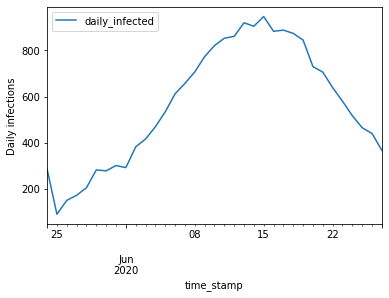

In [56]:
summary.groupby(['time_stamp']).sum().plot(y=['daily_infected'])
plt.ylabel('Daily infections')
plt.show()

### Hospital and intensive care

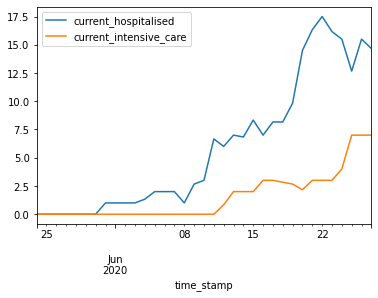

In [57]:
summary.groupby(['time_stamp']).sum().plot(y=['current_hospitalised', 'current_intensive_care'])
plt.show()

### Cumulative infections by age

In [58]:
infections_df = read.get_table_with_extras('infections',
                                           'infected_ids')

2022-02-07 14:21:03,783 - june.records.records_reader - INFO - Loading infections table
2022-02-07 14:21:03,818 - june.records.records_reader - INFO - Loading population table
2022-02-07 14:21:03,864 - june.records.records_reader - INFO - Merging infection and population tables
2022-02-07 14:21:03,875 - june.records.records_reader - INFO - Loading geography table
2022-02-07 14:21:03,899 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [59]:
deaths_df = read.get_table_with_extras('deaths', 
                                       'dead_person_ids')

2022-02-07 14:21:03,923 - june.records.records_reader - INFO - Loading deaths table
2022-02-07 14:21:03,931 - june.records.records_reader - INFO - Loading population table
2022-02-07 14:21:03,981 - june.records.records_reader - INFO - Merging infection and population tables
2022-02-07 14:21:03,984 - june.records.records_reader - INFO - Loading geography table
2022-02-07 14:21:04,009 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [60]:
age_bins = (0,20,60,100)

In [61]:
infected_by_age = infections_df.groupby([pd.cut(infections_df['age'],
            bins=age_bins), 'timestamp']).size()

In [62]:
people_df = read.table_to_df('population')

In [63]:
n_by_age = people_df.groupby(pd.cut(people_df['age'],
            bins=age_bins)).size()

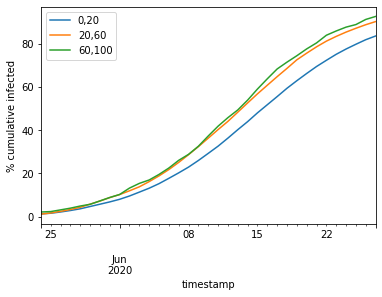

In [64]:
(100*infected_by_age/n_by_age).xs(10).cumsum().plot(label='0,20')
(100*infected_by_age/n_by_age).xs(30).cumsum().plot(label='20,60')
(100*infected_by_age/n_by_age).xs(70).cumsum().plot(label='60,100')
plt.ylabel("% cumulative infected")
plt.legend()

### Where people get infected

In [65]:
locations_df = infections_df.groupby(['location_specs', 
                                'timestamp']).size()

<AxesSubplot:xlabel='timestamp'>

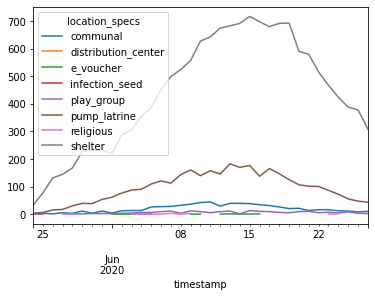

In [66]:
locations_df.unstack(level=0).plot()

Text(0.5, 0, 'location')

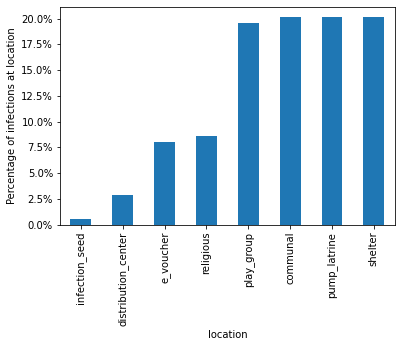

In [67]:
import matplotlib.ticker as mtick
location_counts_df = locations_df.groupby('location_specs').size()
location_counts_df = 100*location_counts_df / location_counts_df.sum()
ax = location_counts_df.sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')

In [68]:
import sys
import importlib
importlib.reload(sys.modules['june.tracker.tracker'])

from june.tracker.tracker import Tracker


#tracker = simulator.tracker

tracker = Tracker.from_pickle(world, Results_Path / "tracker.pkl")
tracker.pickle_path =  Results_Path

tracker.contract_matrix("5yr")
tracker.contract_matrix("AC", np.array([0,18,60]))
tracker.contract_matrix("All", np.array([0,100]))
tracker.make_plots()

Loading from pkl...
Loaded
